### Dataset 
https://www.kaggle.com/benhamner/sf-bay-area-bike-share 


### Exercise 
Analyse the data or a relevant subset of the data and provide insights that is useful for  stakeholders (e.g., for the bike operator company). Based on the insights, where possible,  suggest approach/es to optimise bike placement/reallocation schedule for the operator by  considering usage patterns during the day and week, weather, and ride-distances. Where  necessary make assumptions and include them in the document. 


In [1]:
import pandas as pd
import numpy as np
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

## Data Visualisation

* Location of Stations in San Franciso Bay Area
* Plotting of longitude and latitude with respect to the GeoMap data using GeoPandas

#### The  plot below describes the concentration of stations spread across San Francisco Bay Area.  The maximum number of stations are located in San Franciso and San Jose city

In [3]:
path_station = r'station.csv'
path_status = r'status.csv'
path_trip = r'trip.csv'
path_weather = r'weather.csv'
map_file=r'map.png'

df_station = pd.read_csv(path_station,index_col=None)
#df_status = pd.read_csv(path_status,index_col=None)


#display(df_station.head(2))
#display(df_status.head(2))
#display(df_trip.head(2))
#display(df_weather.head(2))

In [4]:
df_station.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [6]:
crs={'init':'epsg:4326'}
geometry=[Point(xy) for xy in zip(df_station['lat'], df_station['long'])]
geo_df=gpd.GeoDataFrame(df_station, crs=crs, geometry=geometry)
rh_m=plt.imread(map_file)

/Users/ulainqu2/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [14]:
rh_m=plt.imread(map_file)
geo_df = df_station
geo_df.head()

,id,name,lat,long,dock_count,city,installation_date,geometry
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,POINT (37.330 -121.902)
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,POINT (37.331 -121.889)
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,POINT (37.334 -121.895)
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,POINT (37.331 -121.893)
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,POINT (37.337 -121.894)


In [15]:
BBox = ((geo_df.long.min(), geo_df.long.max(),      
         geo_df.lat.min(), geo_df.lat.max()))

In [17]:
geo_df['city'].value_counts()

San Francisco    35
San Jose         16
Redwood City      7
Mountain View     7
Palo Alto         5
Name: city, dtype: int64

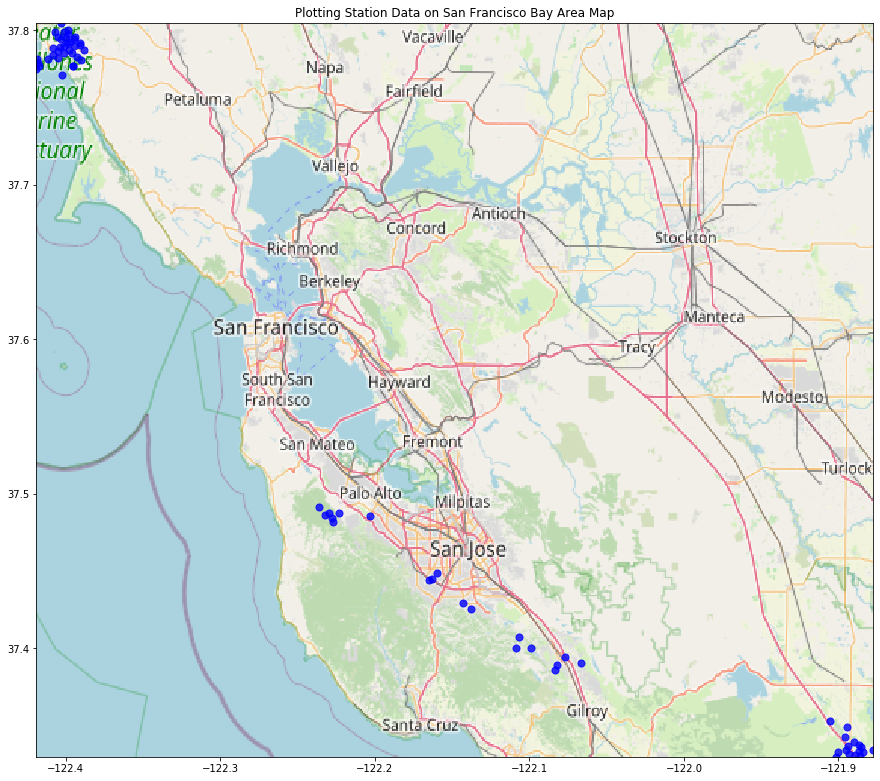

In [16]:
fig, ax=plt.subplots(figsize=(15,15))
ax.scatter(df_station['long'],df_station['lat'],zorder=1, alpha=0.8, c='blue', s=50)
ax.set_title('Plotting Station Data on San Francisco Bay Area Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(rh_m, zorder=0, extent = BBox, aspect= 'equal')

## Data Preparation 
* Summarisation of Trip and Weather data

In [6]:
def trip_data_summary(trip_input, trip_output):
    """
    This function takes trip information and outputs csv file with summarized
    trip information. 
    """
    with open(trip_output, 'w') as f_out:
        # set up csv writer object        
        out_colnames = ['duration', 'date', 'start_year',
                        'start_month', 'start_hour', 'weekday',
                        'start_city', 'end_city', 'subscription_type']        
        trip_write = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_write.writeheader()
        
        for data_file in trip_input:
            with open(data_file, 'r') as f_in:
                trip_read = csv.DictReader(f_in)
                for row in trip_read:
                    new_point = {}
                    
                    ### Convert durations from seconds to minutes.     ###
                    new_point['duration'] = float(row['duration'])/60 
                    
                    # Split datestrings into multiple columns                
                    trip_date = datetime.strptime(row['start_date'], '%m/%d/%Y %H:%M')
                    new_point['date']  = trip_date.strftime('%Y-%m-%d')
                    new_point['start_year']  = trip_date.strftime('%Y')
                    new_point['start_month'] = trip_date.strftime('%m')
                    new_point['start_hour']  = trip_date.strftime('%H')
                    new_point['weekday']     = trip_date.strftime('%A')
                    
                    # remap start and end terminal with start and end city
                    new_point['start_city'] = row['start_station_name']
                    new_point['end_city'] = row['end_station_name']
                    new_point['subscription_type'] = row['subscription_type']
                
                    # write summary to the output file.
                    trip_write.writerow(new_point)

In [7]:
df_weather = pd.read_csv(path_weather,index_col=None)
df_weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


* Merging trip data and Weather data for analysis
* Conversion of trip duration to minutes from seconds

In [8]:
path_station = r'station.csv'
# path_status = r'status.csv' # Not using trip status
path_trip = r'trip.csv'
path_weather = r'weather.csv'

df_trip = pd.read_csv(path_trip,index_col=None)
df_weather = pd.read_csv(path_weather,index_col=None)

## Create sample data
trip_input = ['trip.csv']
trip_output = 'trip_summary.csv'
trip_data_summary(trip_input, trip_output)

# Load in the summarized trip data file as a dataframe
trip_data = pd.read_csv(trip_output)

trip_data.index = pd.to_datetime(trip_data["date"], format='%Y-%m-%d')

df_weather.index = pd.to_datetime(df_weather["date"], format='%m/%d/%Y')
df_weather_sample = df_weather[['mean_temperature_f', 'mean_humidity',
                                'mean_visibility_miles','mean_wind_speed_mph',
                                'zip_code']]

#display(trip_data.shape)
#display(df_weather.shape)

# Merge weather and trip data
sample_data = trip_data.merge(df_weather_sample, left_index=True, right_index=True, how='inner')

display(sample_data.shape)
display(sample_data.head())

(3349795, 14)

,duration,date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type,mean_temperature_f,mean_humidity,mean_visibility_miles,mean_wind_speed_mph,zip_code
date,,,,,,,,,,,,,,
2013-08-29,1.05,2013-08-29,2013,8,14,Thursday,South Van Ness at Market,South Van Ness at Market,Subscriber,68.0,75.0,10.0,11.0,94107
2013-08-29,1.05,2013-08-29,2013,8,14,Thursday,South Van Ness at Market,South Van Ness at Market,Subscriber,71.0,79.0,10.0,6.0,94063
2013-08-29,1.05,2013-08-29,2013,8,14,Thursday,South Van Ness at Market,South Van Ness at Market,Subscriber,71.0,71.0,10.0,8.0,94301
2013-08-29,1.05,2013-08-29,2013,8,14,Thursday,South Van Ness at Market,South Van Ness at Market,Subscriber,70.0,72.0,10.0,5.0,94041
2013-08-29,1.05,2013-08-29,2013,8,14,Thursday,South Van Ness at Market,South Van Ness at Market,Subscriber,72.0,69.0,10.0,7.0,95113


In [25]:
sample_data.describe()

,duration,start_year,start_month,start_hour,mean_temperature_f,mean_humidity,mean_visibility_miles,mean_wind_speed_mph,zip_code
count,3.349795e+06,3.349795e+06,3.349795e+06,3.349795e+06,3.347384e+06,3.308976e+06,3.335561e+06,3.349363e+06,3.349795e+06
mean,1.846583e+01,2.014213e+03,6.476844e+00,1.309612e+01,6.213249e+01,6.676808e+01,9.878739e+00,6.025384e+00,9.432500e+04
std,3.709237e+02,6.838566e-01,3.276796e+00,4.554507e+00,6.962303e+00,1.083429e+01,1.436823e+00,3.257576e+00,4.045601e+02
min,1.000000e+00,2.013000e+03,1.000000e+00,0.000000e+00,3.800000e+01,2.400000e+01,4.000000e+00,0.000000e+00,9.404100e+04
25%,5.733333e+00,2.014000e+03,4.000000e+00,9.000000e+00,5.700000e+01,6.100000e+01,1.000000e+01,4.000000e+00,9.406300e+04
50%,8.616667e+00,2.014000e+03,7.000000e+00,1.300000e+01,6.200000e+01,6.800000e+01,1.000000e+01,6.000000e+00,9.410700e+04
75%,1.258333e+01,2.015000e+03,9.000000e+00,1.700000e+01,6.800000e+01,7.300000e+01,1.000000e+01,8.000000e+00,9.430100e+04
max,2.878400e+05,2.015000e+03,1.200000e+01,2.300000e+01,8.400000e+01,9.600000e+01,2.000000e+01,2.300000e+01,9.511300e+04


## 1. Trip Duration Statistics

In [26]:
# Compute statistics for trip durations.
duration_mean = sample_data['duration'].mean()
duration_qtiles = sample_data['duration'].quantile([.25, .5, .75]).tolist()

In [27]:
print('The average duration of trips is {:.2f} minutes.'.format(duration_mean))
print('The median trip duration is {:.2f} minutes.'.format(duration_qtiles[1]))
print('25% of trips are shorter than {:.2f} minutes.'.format(duration_qtiles[0]))
print('25% of trips are longer than {:.2f} minutes.'.format(duration_qtiles[2]))

The average duration of trips is 18.47 minutes.
The median trip duration is 8.62 minutes.
25% of trips are shorter than 5.73 minutes.
25% of trips are longer than 12.58 minutes.


## 2. Frequency of trips per subscription type

In [28]:
df_freq=pd.DataFrame(sample_data['subscription_type'].value_counts())

In [31]:
df_freq.rename(columns={'type':'subscription_type', 'subscription_type':"trip_freq"})

,trip_freq,subscription_type
Subscriber,2833730,Subscriber
Customer,516065,Customer


Text(0, 0.5, 'Number of Trips')

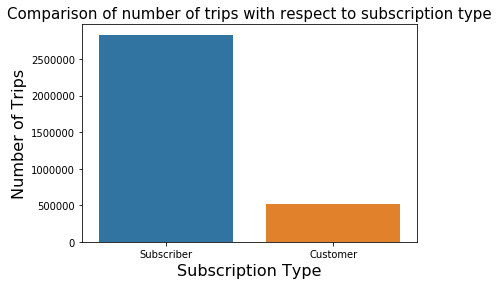

In [29]:
import seaborn as sns
data1 = df_freq.reset_index()
ax = sns.barplot(data=data1, x='index', y='subscription_type')
plt.title('Comparison of number of trips with respect to subscription type', fontsize=15)
plt.xlabel('Subscription Type', fontsize=16)
plt.ylabel('Number of Trips', fontsize=16)

* Helper funtions to filter data and plot different analysis shown below

In [33]:
def data_filter(data, condition):
    """
    This function implements the filter the data based on 
    following conditions >, <, >=, <=, ==, !=
    Handling exceptions from the above cases
    """

    field, op, value = condition.split(" ", 2)
    
    if field not in data.columns.values :
        raise Exception("'{}' is not found in the dataframe.".format(field))

    try:
        value = float(value)
    except:
        value = value.strip("\'\"")

    if op == ">":
        matches = data[field] > value
    elif op == "<":
        matches = data[field] < value
    elif op == ">=":
        matches = data[field] >= value
    elif op == "<=":
        matches = data[field] <= value
    elif op == "==":
        matches = data[field] == value
    elif op == "!=":
        matches = data[field] != value
    else: 
        raise Exception("Only >, <, >=, <=, ==, != comparison operator allowed.")
    
    data = data[matches].reset_index(drop = True)
    return data

def plot_trips(data, 
               key = '',
               filters = [],
               datalabel=None,
               data1=None,
               key1=None,
               filters1=None,
               data1label=None,
               tag=None
              ):
    """
    Plot function for number of trips bsed on a given feature. 
    Function takes a number of optional arguments for plotting data on 
    continuously-valued variables:
    """
    
    if not key:
        raise Exception("Provide a variable on which to plot the data.")
    if key not in data.columns.values :
        raise Exception("'{}' feature is not available in the dataframe. ".format(key))
    if key1 and data1 is not None:
        if key1 not in data1.columns.values :
            raise Exception("'{}' feature is not available in the dataframe. ".format(key))
    
    # Check for conditions
    for condition in filters:
        data = data_filter(data, condition)
        if data1 is not None:
            data1 = data_filter(data1, condition)

    plt.figure(figsize=(7,4))
    
    if isinstance(data[key][0] , str): # Categorical features
        # For strings, collect unique strings and then count number of
        # outcomes for survival and non-survival.

        # Summarize dataframe to get counts in each group
        data['count'] = 1
        data = data.groupby(key, as_index = False).count()
        levels = data[key].unique()
        n_levels = len(levels)
        
        bar_width = 0.8

        for i in range(n_levels):
            trips_bar = plt.bar(i - bar_width/2, data.loc[i]['count'], width = bar_width)

            # add labels to ticks for each group of bars.
        plt.xticks(range(n_levels), levels)
        plt.ylabel("Number of Trips", fontsize=16)

    else: # Numeric features
        if datalabel is None:
            sns.distplot(data[key], color='red', bins=10)
        if datalabel is not None:
            sns.distplot(data[key], color='red', bins=10, label=datalabel)
        if key1 is not None and data1 is not None and data1label is not None:
            sns.distplot(data1[key1], color='blue', bins=10, label=data1label)
        if key1 and data1 is not None:
            sns.distplot(data1[key1], color='blue', bins=10)
        plt.ylabel("Normalized Trips", fontsize=16)
        
    # Common attributes for plot formatting
    key_name = ' '.join([x.capitalize() for x in key.split('_')])

    if datalabel or data1label is not None:
        plt.legend(prop={'size': 12})
    plt.xlabel(key_name, fontsize=16)
    if tag is not None:
        plt.title("Number of {:s} Trips by {:s}".format(tag, key_name), fontsize=18)
    else:
        plt.title("Number of Trips by {:s}".format(key_name), fontsize=18)
    plt.show()

## 3. Number of trips by a Customers and Subscribers in less than 60 minutes

#### The analysis above represents that the average duration of trips is greater for customer group as compared to subscriber. 70% of the subscriber's trips are completed in less than 18 minutes. 

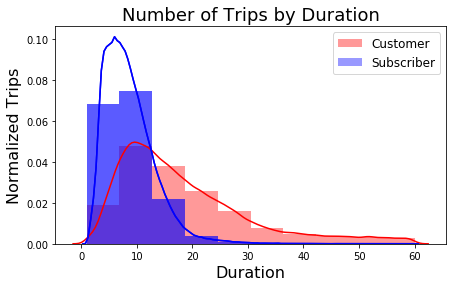

In [34]:
plot_trips(data=sample_data[sample_data['subscription_type']=="Customer"], key='duration', filters=['duration < 60'], datalabel="Customer", data1=sample_data[sample_data['subscription_type']=="Subscriber"], key1='duration', filters1=['duration < 60'], data1label="Subscriber")

## 4. Impact of Weather on Bike Usage

In [38]:
sample_data.head()

,duration,date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type,mean_temperature_f,mean_humidity,mean_visibility_miles,mean_wind_speed_mph,zip_code
date,,,,,,,,,,,,,,
2013-08-29,1.05,2013-08-29,2013,8,14,Thursday,South Van Ness at Market,South Van Ness at Market,Subscriber,68.0,75.0,10.0,11.0,94107
2013-08-29,1.05,2013-08-29,2013,8,14,Thursday,South Van Ness at Market,South Van Ness at Market,Subscriber,71.0,79.0,10.0,6.0,94063
2013-08-29,1.05,2013-08-29,2013,8,14,Thursday,South Van Ness at Market,South Van Ness at Market,Subscriber,71.0,71.0,10.0,8.0,94301
2013-08-29,1.05,2013-08-29,2013,8,14,Thursday,South Van Ness at Market,South Van Ness at Market,Subscriber,70.0,72.0,10.0,5.0,94041
2013-08-29,1.05,2013-08-29,2013,8,14,Thursday,South Van Ness at Market,South Van Ness at Market,Subscriber,72.0,69.0,10.0,7.0,95113


### Both subscribers and customers prefer to use bike service at following optimal weather conditions:
     * Temperature between 60-70 Farenheit
     * Humidity  between 60- 75 
     * Visibility  
     * Wind speed is less than 12 miles/hr

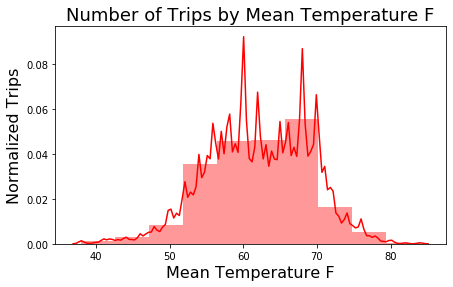

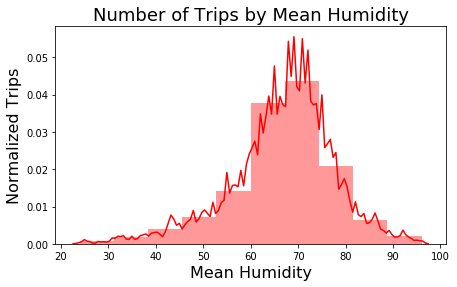

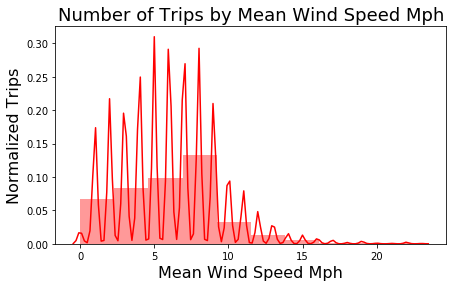

In [39]:
plot_trips(data=sample_data, key='mean_temperature_f')
plot_trips(data=sample_data, key='mean_humidity')
#plot_trips(data=sample_data, key='mean_visibility_miles')
plot_trips(data=sample_data, key='mean_wind_speed_mph')

## 5. Impact of Week Days on the Bike Usage

#### The analysis plots below describe the usage of bikes by both subscriber and customer groups. The key insights from this analysis are following:
    * Subscribers tend to use the bike service more on week days (Monday to Friday)
    * Customers tend to use bike service more on weekends 

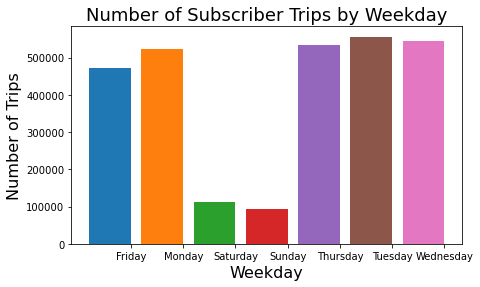

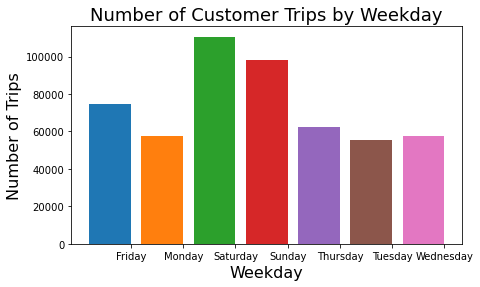

In [22]:
plot_trips(data=sample_data, key='weekday', filters=["subscription_type == 'Subscriber'"], tag='Subscriber')
plot_trips(data=sample_data, key='weekday', filters=["subscription_type == 'Customer'"], tag='Customer')

## 6. Hourly Bike Usage For Subscribers and Customers During Busy Days

#### The analysis plots below describe the usage of bikes in terms of hour of the day, by both subscriber and customer groups. The key insights from this analysis are following:
 * Since the subscriber group is using the bikes more on weekdays, it is evident that they are using the bike service during office hours (i.e. in the morning 8-10am and in the evenings 3pm-7pm)
 * The customer group however, uses the bike service during afternoon on the weekends

C:\Users\Arslan\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


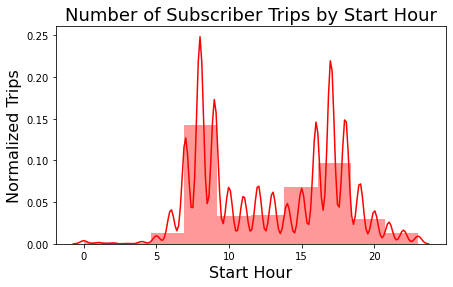

C:\Users\Arslan\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


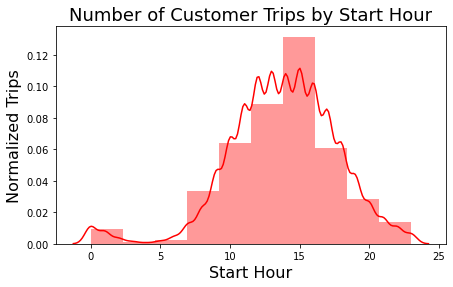

In [23]:
plot_trips(data=sample_data, key='start_hour', filters=[("weekday != 'Saturday'") and ("weekday != 'Sunday'"), "duration < 60", "subscription_type == 'Subscriber'"], tag='Subscriber')
plot_trips(data=sample_data, key='start_hour', filters=[("weekday == 'Saturday'") and ("weekday == 'Sunday'"), "duration < 60", "subscription_type == 'Customer'"], tag='Customer')

## 7. Time Series Data Mining

## Analysis Performed:
Since the dataset provided is longitudnal data. The measurements (trip duration, weather, frequency etc.) span between year 2013 and 2015, in the below analysis, I perform time series data mining analysis. The objective of this analysis is
* to understand if the time series is stationary or non-stationary
* to understand each feature individually in terms of seasonalities, trend, residue
* to understand if the features are discreet or continuous
* to understand if we can determine the period for seasonal time series

## Summarised Findings:
Here I summarise the initial findings of the analysis performed below
* All features in this time series are stationary
* There are no seasons found in this time series
* All features in this time series are continous 
* Simple forecasting can be applied on some features using Autocorrelation based methods, such as ARIMA.
* None of the time series (features) evolve in terms of seasons or trends
* Since there is no evolution in time series, simple box plot methods can be used to identify anomalies in this dataset based on statistical thresholds. Therefore, we applied robust and published box plot anamoly detection algorithm. This method uses median absolute deviation instead of interquartile range to calculate thresholds.
 

In [144]:
import logging
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, find_peaks_cwt

logging.disable(logging.WARNING)
warnings.filterwarnings('ignore')


def adf_test(time_series):
    dftest = adfuller(time_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
        'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    if dfoutput['p-value'] < 0.01:
        return True, dfoutput
    else:
        return False, dfoutput


def kpss_test(time_series):
    kpsstest = kpss(time_series, regression='c')
    dfoutput = pd.Series(kpsstest[0:3], index=[
        'Test Statistic', 'p-value', 'Lags Used'])
    for key, value in kpsstest[3].items():
        dfoutput['Critical Value (%s)' % key] = value

    if dfoutput['p-value'] < 0.01:
        return False, dfoutput
    else:
        return True, dfoutput


def most_frequent(list):
    counter = 0
    num = list[0]

    for i in list:
        curr_frequency = list.count(i)
        if curr_frequency > counter:
            counter = curr_frequency
            num = i
    return num


def identify_cont_disc(df):
    """
    :param df: the metric data column(s) that has no NAN or constant values
    :return: list of continuous metrics and their corresponding data column(s)
    """
    raw_feature_list = df.columns
    raw_feature_list = list(raw_feature_list.values)

    # feature_list = df.columns
    discrete_features = []
    continuous_features = []
    for colum in raw_feature_list:
        if len(df[colum].unique()) < 20:
            # print(colum, ': ', df[colum].unique())
            discrete_features.append(colum)
        else:
            # print(colum, ": continuous features")
            continuous_features.append(colum)
    df_cont = df[continuous_features].copy()

    df_disc = df[discrete_features].copy()

    return continuous_features, discrete_features


def analysisPeriod(df_raw, feature, time_feature, plot=False, verbose=False):
    """
    :param df_raw: data set
    :param feature: metric name
    :param time_feature: time series name
    :param plot: visual analysis functionality
    :param verbose: print details on the console
    :return: stationary, seasonal, period, decomposed series
    """

    ## INITIALIZATION: time series should be normalised into [0, 1]

    seasonal = False
    stationary = False
    df_ts = df_raw.copy()

    # Stationary Check
    # ADF TEST: Augmented Dickey–Fuller test
    # KPSS TEST: Kwiatkowski–Phillips–Schmidt–Shin TEST
    adf_result, adf_output = adf_test(df_ts[feature])
    kpss_result, kpss_output = kpss_test(df_ts[feature])

    if verbose:
        print('adf-Test')
        print(adf_result)
        print(adf_output)
        print('kpss-Test')
        print(kpss_result)
        print(kpss_output)

    # This is the code to use two tests, it will return true for stationary if or(test1,test2) = True
    if adf_result == True & kpss_result == True:
        stationary = True
    elif adf_result == True & kpss_result == False:
        stationary = False
        print("Difference Stationary")
    elif adf_result == False & kpss_result == True:
        stationary = False
        print("Trend Stationary")
    else:
        stationary = False

    # First: checking flat line.
    if np.all(np.isclose(df_ts[feature].values, df_ts[feature].values[0])):
        print('Constant series')
        seasonal = False
        period = 1
        result_add = None
    else:
        # If not flat line then:
        # Seasonality Check:

        # Automatic find the period based on Time Index

        # Shift windows to find autocorrelations
        shift_ = []
        for i in np.arange(len(df_ts[feature])):
            shift_.append(df_ts[feature].autocorr(lag=i))
        shift_ = np.array(shift_)

        # if max of Autocorelation greater than 0.9, we have seasonal
        if max(shift_) >= 0.9:
            seasonal = True

        # find peaks of autocorelation -> in order to find local maxima
        # peaks, _ = find_peaks(shift_, height=0.5)
        peaks = find_peaks_cwt(shift_, np.arange(1, 10))

        # turn peaks into differences between peaks
        diff = []
        for i in np.arange(len(peaks) - 1):
            diff.append(peaks[i + 1] - peaks[i])

        if len(diff) == 0:  # can't find peaks
            first_period = 1  # need to check again this!
        else:
            # return the most distance between peaks -> that is period of data
            first_period = most_frequent(list(diff))

        if verbose:
            #print('Candidate periods:', set(diff))
            for eachdiff in diff:
                print(df_ts[feature].autocorr(lag=eachdiff), end='\t')
            print()

        if (plot == True) & (verbose == True):
            plt.figure(figsize=(20, 3))
            sm.graphics.tsa.plot_acf(
                df_ts[feature].squeeze(), lags=int(first_period))

        # if period is too large
        if first_period > int(len(df_ts) / 2):
            if verbose:
                print('Frequency for Moving Average is over half size!')
            first_period = int(len(df_ts) / 2)

        # SEASONAL ANALYSIS

        if verbose:
            print('First period:', first_period)

        df_ts.index = pd.to_datetime(
            df_ts[time_feature], format='%Y-%m-%d %H:%M:%S')
        rolling_mean = df_ts[feature].rolling(
            window=int(first_period)).mean()
        exp1 = pd.Series(df_ts[feature].ewm(
            span=int(first_period), adjust=False).mean())
        exp1.index = pd.to_datetime(
            df_ts[time_feature], format='%Y-%m-%d %H:%M:%S')

        if (verbose == True) & (plot == True):
            df_ori = df_ts[[feature, time_feature]].copy()
            df_ori.set_index(time_feature, inplace=True)

            fig, ax = plt.subplots(figsize=(15, 4))

            df_ori.plot(ax=ax)
            exp1.plot(ax=ax)

            ax.legend(
                ['Original Series', 'Moving Average Series with P=%d' % first_period])

            plt.show()

        # Using Moving Average
        result_add = seasonal_decompose(
            exp1, model='additive', extrapolate_trend='freq', freq=first_period)

        # Using STL
        #         from statsmodels.tsa.seasonal import STL
        #         stl = STL(exp1, period=first_period, robust=True)
        #         result_add = stl.fit()

        # Only check the seasonal series to find again the best period
        arr_seasonal_ = pd.Series(result_add.seasonal + result_add.resid)

        # if seasonal is flat
        if np.all(np.isclose(arr_seasonal_, arr_seasonal_[0])):
            if verbose == True:
                print('Seasonal + Residual become flat')
            seasonal = False
            period = 1
        else:
            # if seasonal is not flat

            # Continue to use autocorrelation to find the period
            shift_ = []
            for i in np.arange(len(arr_seasonal_)):
                shift_.append(arr_seasonal_.autocorr(lag=i))

            shift_ = np.array(shift_)

            # Find peaks again for seasonal + residual
            peaks, _ = find_peaks(shift_, height=0.85, distance=7)
            #             peaks = find_peaks_cwt(shift_,np.arange(1,10))

            # Looking for possible periods
            if len(peaks) < 2:
                if df_ts[feature].autocorr(lag=first_period) > 0.80:
                    period = first_period
                    seasonal = True
                else:
                    period = 1
                    seasonal = False
                    result_add = None
            # result_add = seasonal_decompose(df_ts[feature], model='additive', extrapolate_trend='freq',freq=period)
            else:
                diff = []
                for i in np.arange(len(peaks)):
                    if i + 1 < len(peaks):
                        diff.append(peaks[i + 1] - peaks[i])

                if verbose:
                    print('Candidate periods:', set(diff))
                    for eachdiff in diff:
                        print(df_ts[feature].autocorr(lag=eachdiff), end='\t')
                    print()

                if verbose:
                    print('Peaks of autocorr:', diff)
                if 2 * most_frequent(list(diff)) > len(df_ts):
                    seasonal = False
                    period = 1
                    result_add = None
                else:
                    seasonal = True
                    period = most_frequent(list(diff))

            if (plot == True) & (verbose == True):
                sm.graphics.tsa.plot_acf(exp1.squeeze(), lags=int(period) * 2)
                plt.show()

            # Final Decomposition

            result_add = seasonal_decompose(
                df_ts[feature], model='additive', extrapolate_trend='freq', freq=period)

            # plot results of decomposition
            if plot:
                plt.rcParams.update({'figure.figsize': (10, 10)})
                result_add.plot()
                plt.show()

                plt.figure(figsize=(20, 3))
                plt.plot(df_ts[feature].values, label="Timeseries")
                plt.axvline(x=0, color='r', ls='--')
                plt.axvline(x=period, color='r', ls='--')
                plt.grid(True)
                plt.axis('tight')
                plt.legend(loc="best", fontsize=13)
                plt.show()

    continuous, discrete = identify_cont_disc(df_raw[[feature]])

    return stationary, seasonal, period, result_add, continuous, discrete

### 7.1 Time Series Data Mining for Weather Data

In [9]:
df_weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
date,,,,,,,,,,,,,,,,,,,,,
2013-08-29,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
2013-08-30,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2013-08-31,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
2013-09-01,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
2013-09-02,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [10]:
df_weather.columns[0]

'date'

adf-Test
True
Test Statistic                   -4.469637
p-value                           0.000223
#Lags Used                       27.000000
Number of Observations Used    2472.000000
Critical Value (1%)              -3.432998
Critical Value (5%)              -2.862710
Critical Value (10%)             -2.567393
dtype: float64
kpss-Test
True
Test Statistic            1.194976
p-value                   0.010000
Lags Used                27.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
0.598088978624195	0.6768048555767845	0.7000751780004899	0.6768048555767845	0.607446053719102	0.47207782856042596	0.6257136563689634	0.6870602471521767	0.7000751780004899	0.6768048555767845	0.5796493515745132	0.6768048555767845	0.6870602471521767	0.6870602471521767	0.7000751780004899	0.6870602471521767	0.6580847997706971	0.8375140421185324	0.4773064900752879	0.9059129884999401	0.47730649007528

<Figure size 1600x240 with 0 Axes>

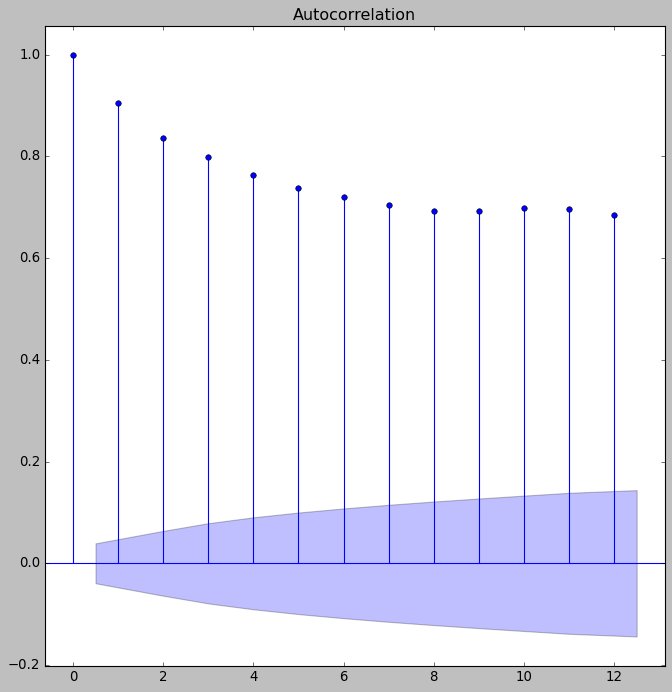

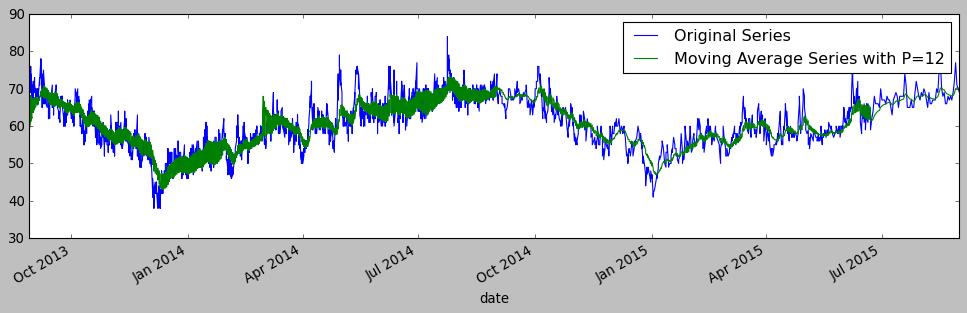

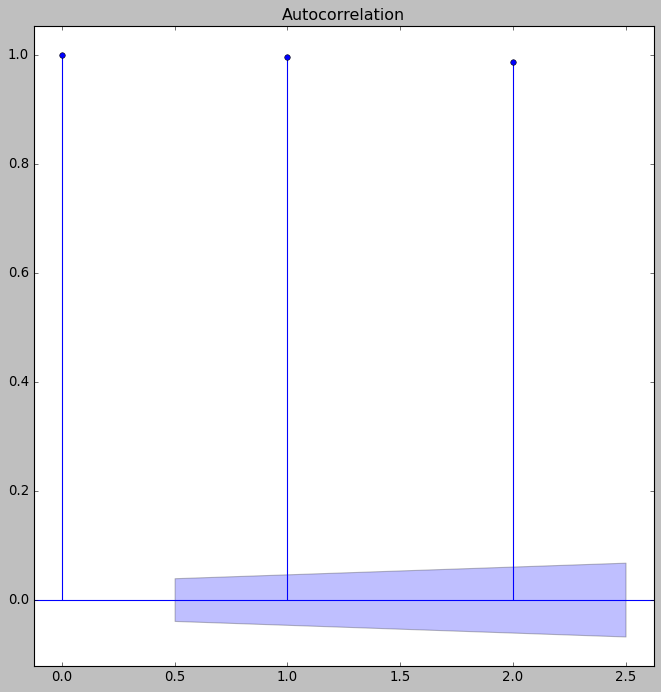

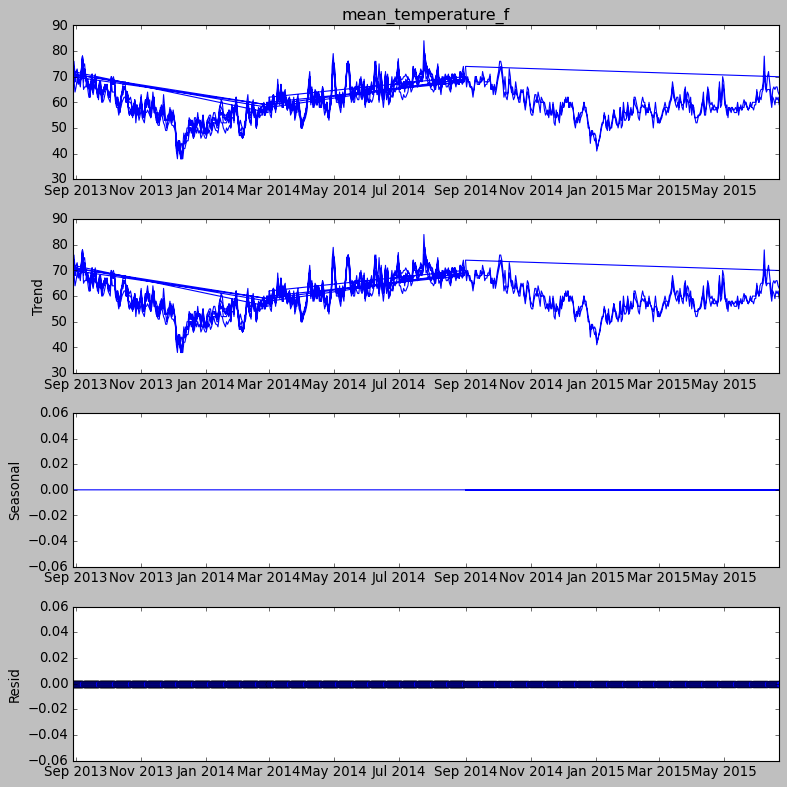

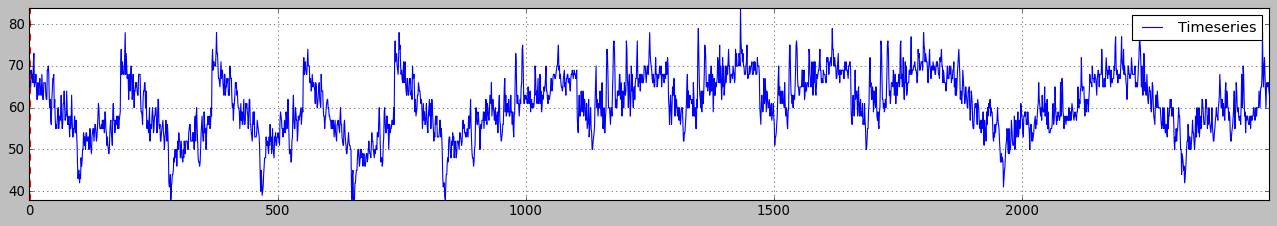

Timeseries mean_temperature_f is Stationary? True 
Timeseries mean_temperature_f is Seasonal? False 
Timeseries mean_temperature_f is Continuous


In [143]:
feature_name = "mean_temperature_f"
df_weather["date"] = pd.to_datetime(df_weather["date"], format='%m/%d/%Y')

timestamp = df_weather.columns[0]

stationary, seasonal, period, resultdfs, continuous, discrete = analysisPeriod(df_weather.head(2500),
                                                                               feature=feature_name,
                                                                               time_feature=timestamp,
                                                                               plot=True,
                                                                               verbose=True)

print("Timeseries %s is Stationary? %s " % (feature_name, stationary))

print("Timeseries %s is Seasonal? %s " % (feature_name, seasonal))

if seasonal and period > 1:
    print("Period for Timeseries %s =  %s " % (feature_name, period))
if seasonal and period == 1:
    print("Period for Timeseries %s is not found" % (feature_name, aperiod))

if continuous:
    print("Timeseries %s is Continuous" % (feature_name))
else:
    print("Timeseries %s is Discrete" % (feature_name))

### 7.2 Time Series Data Mining for Trip Data

adf-Test
True
Test Statistic                -1.620194e+01
p-value                        4.068801e-29
#Lags Used                     3.000000e+00
Number of Observations Used    2.996000e+03
Critical Value (1%)           -3.432535e+00
Critical Value (5%)           -2.862505e+00
Critical Value (10%)          -2.567284e+00
dtype: float64
kpss-Test
True
Test Statistic            0.674113
p-value                   0.015899
Lags Used                29.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
0.06399496136946782	0.46349859103016283	0.12982842702602848	0.46349859103016283	0.11512110652063486	0.1324788171725577	0.10564804648818026	0.1324788171725577	0.08492528276325477	0.1300827198643906	0.10600357158628546	0.056333635448994425	0.12751391290875363	0.12751391290875363	0.12747729933522686	0.117954485322955	0.1324788171725577	0.16202779541255038	0.12982842702602848	0.12747729933

<Figure size 1600x240 with 0 Axes>

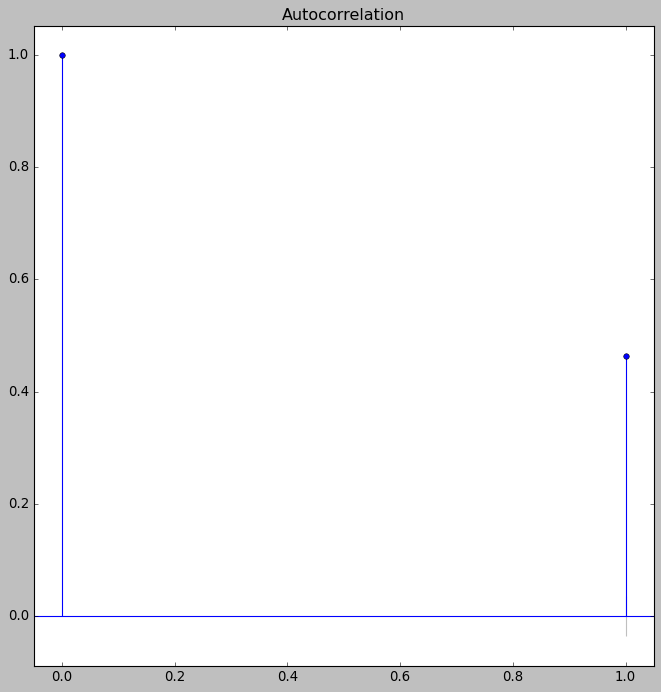

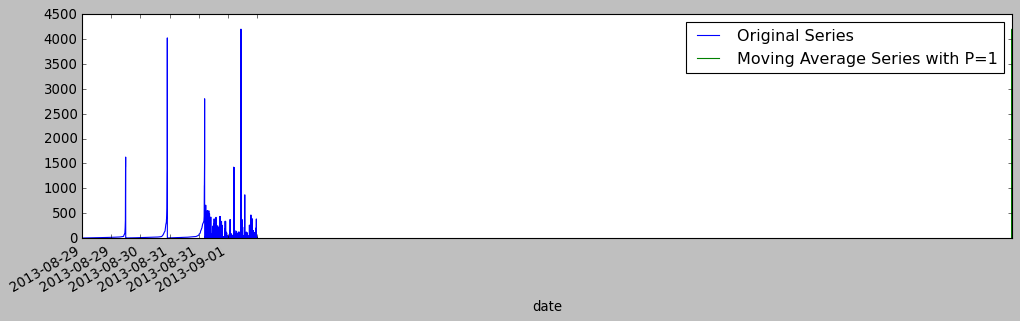

Seasonal + Residual become flat
Timeseries duration is Stationary? True 
Timeseries duration is Seasonal? False 
Timeseries duration is Continuous


In [132]:
feature_name = "duration"

timestamp = trip_data.columns[1]

stationary, seasonal, period, resultdfs, continuous, discrete = analysisPeriod(trip_data.head(3000),
                                                                               feature=feature_name,
                                                                               time_feature=timestamp,
                                                                               plot=True,
                                                                               verbose=True)

print("Timeseries %s is Stationary? %s " % (feature_name, stationary))

print("Timeseries %s is Seasonal? %s " % (feature_name, seasonal))

if seasonal and period > 1:
    print("Period for Timeseries %s =  %s " % (feature_name, period))
if seasonal and period == 1:
    print("Period for Timeseries %s is not found" % (feature_name, period))

if continuous:
    print("Timeseries %s is Continuous" % (feature_name))
else:
    print("Timeseries %s is Discrete" % (feature_name))

### 7.3 Timeseries Anomaly Detection using Robust BoxPlot
(https://www.researchgate.net/publication/344378625_SLMAD_Statistical_Learning-Based_Metric_Anomaly_Detection) 

In [115]:
import matplotlib.pyplot as plt


def plotTest(test_data, feature_name, plot_bound=False):
    """
    :param test_data: the data set used for testing the anomalies
    :param feature_name: metric tag evaluated for anomalies
    :param plot_bound: boolean indicating if lower and upper bounds should appear in the plots
    :return: None
    """
    series = test_data[feature_name]
    outlier = test_data[feature_name].loc[test_data['Anomaly'] == 1]
    if plot_bound:
        lower_bound = test_data['LowerBound']
        upper_bound = test_data['UpperBound']
        plotOutlier(series, feature_name, outlier, lower_bound, upper_bound)
    else:
        plotOutlier(series, feature_name, outlier)


def plotOutlier(data, feature_name, data_ole, lower_bound=None, upper_bound=None, figure_size=(15, 8)):
    """
    :param data: the data set used for testing the anomalies
    :param feature_name: feature_name
    :param data_ole: the anomalous data points
    :param lower_bound: from a box plot
    :param upper_bound: from a box plot
    :param figure_size: the plot/chart size in (width, height)
    :return: None
    """
    plt.style.use('classic')
    # plt.figure(figsize=figure_size, facecolor='white')
    fig = plt.figure(figsize=figure_size, facecolor='white')
    ax = plt.subplot(111)
    plt.plot(data, '.k-', label="Time Series", alpha=0.9, linewidth=3)
    plt.plot(data_ole, "o",
             markersize=10,
             label="Anomalies",
             markerfacecolor='red',
             markeredgecolor='red', mew=2, alpha=0.5)

    if (lower_bound is not None) & (upper_bound is not None):
        plt.plot(lower_bound, "k.-", alpha=0.3, label="Up/Low confidence")
        plt.plot(upper_bound, "k.-", alpha=0.3)
        plt.fill_between(x=data.index, y1=upper_bound.values,
                         y2=lower_bound.values, alpha=0.2, color="green")

    plt.grid(True)
    plt.axis('tight')
    plt.xlabel("Time series")
    plt.ylabel("%s" %feature_name)
    ax.legend(loc='lower left', bbox_to_anchor=(0.0, 1.01), ncol=2,
              borderaxespad=0, frameon=False)
    plt.show()

def trainBaseBoxPlot(data, tukey=False, robust=True, bowley=False):
    """ Whisker Box Plot Training Algorithm
    :param tukey: Upper bound and lower bound using tukey's rule
    :param bowley: Upper bound and lower bound using bowley's coefficient
    :param robust: Upper bound and lower bound using median absolute deviation
    :param data: training data for the metric
    :return: a lower and upper bound
    """

    train_data = data

    q1 = np.quantile(train_data, .25)
    q3 = np.quantile(train_data, .75)

    # Box-Plot using Tukey's Rule
    if tukey:
        q1 = np.quantile(train_data, .25)
        q3 = np.quantile(train_data, .75)
        iqr = q3 - q1
        LowerBound = (q1 - 1.5 * iqr)
        UpperBound = (q3 + 1.5 * iqr)

    # Box-Plot using Bowley's coefficient
    if bowley:
        iqr = q3 - q1
        q2 = np.quantile(train_data, .50)
        s_iqr_l = q2 - q1
        s_iqr_u = q3 - q2
        UpperBound = (q1 - 1.5 * iqr * (s_iqr_l / s_iqr_u))
        LowerBound = (q3 + 1.5 * iqr * (s_iqr_u / s_iqr_l))

    # Box-Plot using robust measure of scale
    if robust:
        mad = stats.median_absolute_deviation(train_data)
        LowerBound = (q1 - 1.44 * mad)
        UpperBound = (q3 + 1.44 * mad)

    return LowerBound, UpperBound


def testBaseBoxPlot(test_data, feature_name, LowerBound, UpperBound):
    """
    :param test_data: the data to be tested for anomalies
    :param feature_name: metric name
    :param LowerBound: calculated LB from training data set
    :param UpperBound: calculated UB from training data set
    :return: output data set with anomalies
    """

    test_data['Anomaly'] = [0] * len(test_data)
    test_data['LowerBound'] = [0] * len(test_data)
    test_data['UpperBound'] = [0] * len(test_data)

    for ind, row in test_data.iterrows():
        test_data['LowerBound'].loc[ind] = LowerBound
        test_data['UpperBound'].loc[ind] = UpperBound
        data = row[feature_name]
        if (data > LowerBound) & (data < UpperBound):
            test_data['Anomaly'].loc[ind] = 0
        else:
            test_data['Anomaly'].loc[ind] = 1

    test_data = test_data.iloc[:, 1:]

    return test_data

In [11]:
df_weather.iloc[:,2:3]

,mean_temperature_f
date,
2013-08-29,68.0
2013-08-30,69.0
2013-08-31,64.0
2013-09-01,66.0
2013-09-02,69.0
...,...
2015-08-27,78.0
2015-08-28,80.0
2015-08-29,72.0


            Anomaly  LowerBound  UpperBound  mean_temperature_f
date                                                           
2013-08-29        1   44.460224   71.539776                68.0
2013-08-29        1   44.460224   71.539776                71.0
2013-08-29        1   44.460224   71.539776                71.0
2013-08-29        1   44.460224   71.539776                70.0
2013-08-29        1   44.460224   71.539776                72.0
...             ...         ...         ...                 ...
2015-08-31        1   44.460224   71.539776                69.0
2015-08-31        1   44.460224   71.539776                71.0
2015-08-31        1   44.460224   71.539776                70.0
2015-08-31        1   44.460224   71.539776                72.0
2015-08-31        1   44.460224   71.539776                72.0

[15825 rows x 4 columns]


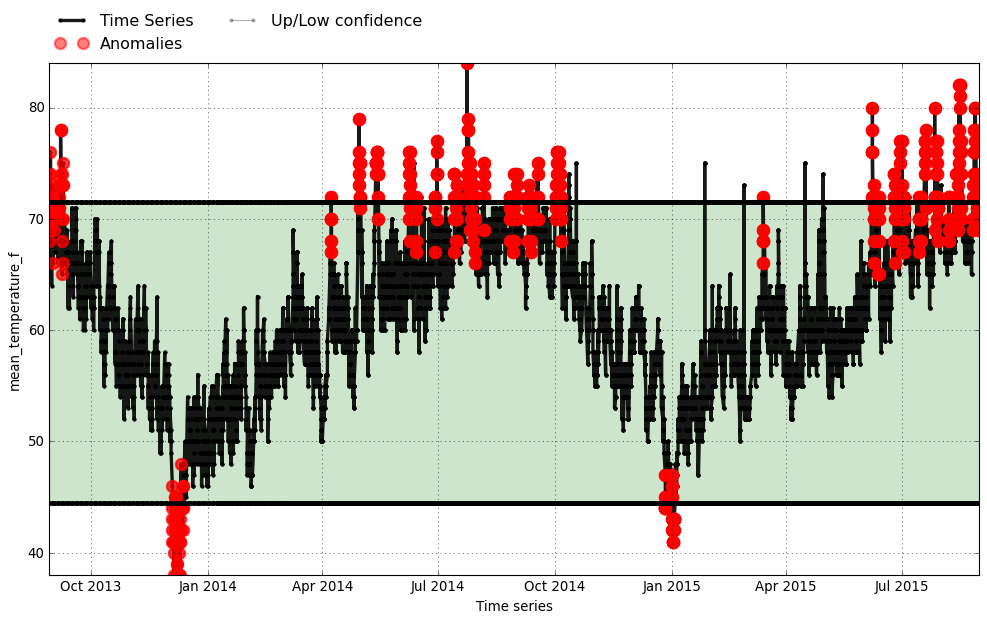

In [126]:
feature_name = "mean_temperature_f"
df_temp = df_weather.iloc[:,2:3]

LB, UB = trainBaseBoxPlot(df_temp[:500],
                          tukey=False,
                          robust=True,
                          bowley=False)

output_data = testBaseBoxPlot(df_temp[500:], feature_name, LB[0], UB[0])

output_data = output_data.merge(df_weather[feature_name], left_index=True, right_index=True, how='inner')

plotTest(output_data, feature_name, plot_bound=True)
plt.show()